<a href="https://colab.research.google.com/github/gerin98/Alarm/blob/master/A4/Assignment_4_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 51kB 5.0MB/s 


In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [12]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)
print("\nTraining ratio: %.2f, Validation ratio: %.2f, Test ratio: %.2f" % (train_ratio, valid_ratio, 1 - train_ratio - valid_ratio))
print("\nTraining samples: %d, Validation samples: %d, Test samples: %d" % (n_train, n_valid, len(X_data) - n_train - n_valid))
print("\nIterations in training set for 1 epoch with a batch size of 32: %d" % (n_train/32))
print("\nIterations in 30 epochs: %d" % (30*n_train/32))

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]


Training ratio: 0.80, Validation ratio: 0.10, Test ratio: 0.10

Training samples: 48000, Validation samples: 6000, Test samples: 6000

Iterations in training set for 1 epoch with a batch size of 32: 1500

Iterations in 30 epochs: 45000



Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), 
                                       objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), 
                                       objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
print(model.vars())

(ConvNet).conv_1(Sequential)[0](Conv2D).b       16 (16, 1, 1)
(ConvNet).conv_1(Sequential)[0](Conv2D).w      192 (2, 2, 3, 16)
(ConvNet).conv_2(Sequential)[0](Conv2D).b       32 (32, 1, 1)
(ConvNet).conv_2(Sequential)[0](Conv2D).w     2048 (2, 2, 16, 32)
(ConvNet).linear(Linear).b                      10 (10,)
(ConvNet).linear(Linear).w                     320 (32, 10)
+Total(6)                                     2618


Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



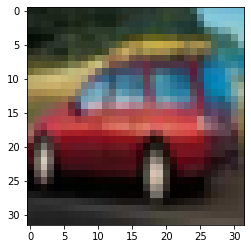

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights.shape)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: (1, 1, 3, 2)
Conv output: [[[[0.12672886 0.12282111 0.11149013 ... 0.6887018  0.68529016
    0.6859305 ]
   [0.16580646 0.14250416 0.15056773 ... 0.7224139  0.7248157
    0.720908  ]
   [0.16971421 0.14626767 0.17010652 ... 0.7471892  0.74827
    0.7349775 ]
   ...
   [0.17194138 0.16412587 0.16412587 ... 0.23945406 0.24336183
    0.2550851 ]
   [0.14458708 0.13677156 0.13677156 ... 0.26290062 0.25899285
    0.25899285]
   [0.12895605 0.12504828 0.12895605 ... 0.31760925 0.31370148
    0.30197823]]

  [[0.05628449 0.05453568 0.04822318 ... 0.4129358  0.40834317
    0.40585515]
   [0.07377251 0.06363551 0.06571121 ... 0.41238704 0.41448894
    0.41274014]
   [0.07552132 0.0650285  0.07445522 ... 0.4012628  0.40620714
    0.4052251 ]
   ...
   [0.07694733 0.07344972 0.07344972 ... 0.08648183 0.08823063
    0.09347704]
   [0.06470571 0.06120811 0.06120811 ... 0.09697466 0.09522586
    0.09522586]
   [0.0577105  0.0559617  0.0577105  ... 0.1214579  0.1197091
    0.11446269]

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  a, RGB, W, H = my_image.shape
  
  K1 = initial_filter_weights.shape[0]
  K2 = initial_filter_weights.shape[1]
  Wout = W - K1 + 1
  Hout = H - K1 + 1
  my_conv_output = np.zeros((1, initial_filter_weights.shape[3], Wout, Hout))

  # loop through image 
  for w in range(W):
    for h in range(H):
      # loop through kernel
      for k1 in range(K1):
        for k2 in range(K2):
          pixel = my_image[:,:,w+k1,h+k2]   # get pixel in image
          pixel_weight = filter_weights[k1,k2,:,:]
          conv = jn.dot(pixel, pixel_weight)   # apply filter
          # place result in the output matrix directly because kernel
          my_conv_output[:,:,w,h] = conv    

  return my_conv_output

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
rearranged = Conv2d(my_image).mean((2,3))
my_conv_output = my_conv_net(my_image, filter_weights)
print("Using Conv2d:", rearranged)
print("Using my_conv_net:", my_conv_output.mean((2,3)))


Using Conv2d: [[0.2895652 0.1107385]]
Using my_conv_net: [[0.28956519 0.11073851]]


Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
num_inputs = my_conv_output.mean((2,3)).shape[1]

Linear_Layer = objax.nn.Linear(num_inputs, 1)
w = np.array(Linear_Layer.w.value).flatten()
b = np.array(Linear_Layer.b.value).flatten()

print("Objax's Linear Layer:", Linear_Layer(my_conv_output.mean((2,3))))
print("My Linear Layer:", jn.dot(my_conv_output.mean((2,3)), w) + b)

Objax's Linear Layer: [[0.1138427]]
My Linear Layer: [0.1138427]


You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):   
      params.value -= learning_rate * grad                
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:(it+BATCH)]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:(it+BATCH)]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.4f Validation Loss %.4f Training Accuracy %.4f Validation Accuracy %.4f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.3072 Validation Loss 2.2922 Training Accuracy 10.7542 Validation Accuracy 14.0667
Epoch 0002  Training Loss 2.2886 Validation Loss 2.2838 Training Accuracy 15.3688 Validation Accuracy 16.8000
Epoch 0003  Training Loss 2.2805 Validation Loss 2.2753 Training Accuracy 16.8562 Validation Accuracy 17.5833
Epoch 0004  Training Loss 2.2725 Validation Loss 2.2674 Training Accuracy 17.2354 Validation Accuracy 18.1667
Epoch 0005  Training Loss 2.2645 Validation Loss 2.2586 Training Accuracy 17.5417 Validation Accuracy 18.2833
Epoch 0006  Training Loss 2.2558 Validation Loss 2.2492 Training Accuracy 17.5896 Validation Accuracy 18.4167
Epoch 0007  Training Loss 2.2461 Validation Loss 2.2389 Training Accuracy 17.6042 Validation Accuracy 18.4833
Epoch 0008  Training Loss 2.2352 Validation Loss 2.2271 Training Accuracy 17.7104 Validation Accuracy 18.7667
Epoch 0009  Training Loss 2.2228 Validation Loss 2.2139 Training Accuracy 17.7479 Validation Accuracy 18.9333
Epoch 0010

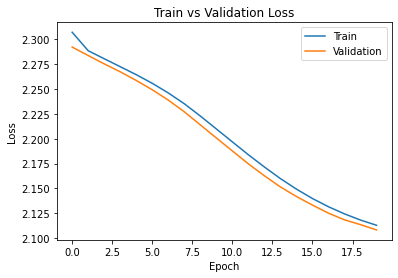

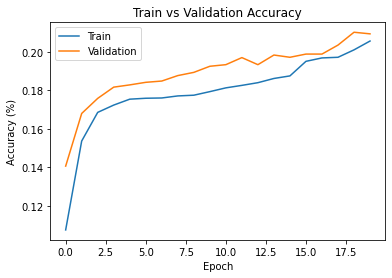

In [ ]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

## Q5. Hyperparameters chosen

### H1
- kernel size: `k=3`
- number of convolutional layers: `3`
- number of outputs of the first hidden layer `16`
- learning rate: `a=0.03`

### H2
- kernel size: `k=5`
- number of convolutional layers: `2`
- number of outputs of the first hidden layer `32`
- learning rate: `a=0.05`

## Using H1 hyperparameters

In [ ]:
class ConvNetM1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(nin=number_of_channels, nout=16, k=3), 
                                       objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(nin=16, nout=32, k=3), 
                                       objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(nin=32, nout=64, k=3), 
                                       objax.functional.relu])
    self.linear = objax.nn.Linear(64, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, size=2, strides=2)
    x = self.conv_2(x)
    x = objax.functional.max_pool_2d(x, size=2, strides=2)
    x = self.conv_3(x)

    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNetM1()
print(model.vars())

(ConvNetM1).conv_1(Sequential)[0](Conv2D).b       16 (16, 1, 1)
(ConvNetM1).conv_1(Sequential)[0](Conv2D).w      432 (3, 3, 3, 16)
(ConvNetM1).conv_2(Sequential)[0](Conv2D).b       32 (32, 1, 1)
(ConvNetM1).conv_2(Sequential)[0](Conv2D).w     4608 (3, 3, 16, 32)
(ConvNetM1).conv_3(Sequential)[0](Conv2D).b       64 (64, 1, 1)
(ConvNetM1).conv_3(Sequential)[0](Conv2D).w    18432 (3, 3, 32, 64)
(ConvNetM1).linear(Linear).b                      10 (10,)
(ConvNetM1).linear(Linear).w                     640 (64, 10)
+Total(8)                                      24234


In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

# Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):  
      params.value -= learning_rate * grad      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Epoch 0001  Training Loss 2.0659 Validation Loss 1.8865 Training Accuracy 27.6208 Validation Accuracy 29.7167
Epoch 0002  Training Loss 1.7943 Validation Loss 1.6820 Training Accuracy 39.3667 Validation Accuracy 37.4167
Epoch 0003  Training Loss 1.6666 Validation Loss 1.5762 Training Accuracy 44.6708 Validation Accuracy 42.2000
Epoch 0004  Training Loss 1.5751 Validation Loss 1.5322 Training Accuracy 49.0521 Validation Accuracy 42.3333
Epoch 0005  Training Loss 1.4968 Validation Loss 1.4964 Training Accuracy 52.4583 Validation Accuracy 45.0167
Epoch 0006  Training Loss 1.4325 Validation Loss 1.3726 Training Accuracy 54.9521 Validation Accuracy 50.2167
Epoch 0007  Training Loss 1.3807 Validation Loss 1.3292 Training Accuracy 57.3937 Validation Accuracy 51.8000
Epoch 0008  Training Loss 1.3298 Validation Loss 1.3534 Training Accuracy 59.6750 Validation Accuracy 52.1667
Epoch 0009  Training Loss 1.2860 Validation Loss 1.2815 Training Accuracy 61.2729 Validation Accuracy 53.2000
Epoch 0010

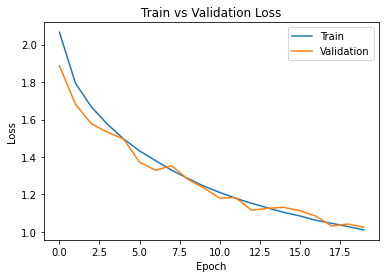

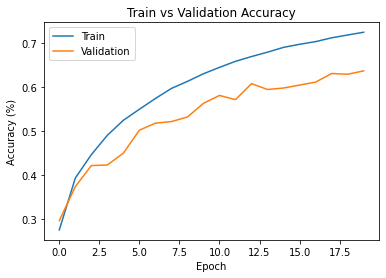

In [ ]:
train(LEARNING_RATE = 0.03)

## Using H2 hyperparameters

In [ ]:
class ConvNetM2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(nin=number_of_channels, nout=32, k=5), 
                                       objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(nin=32, nout=32, k=5), 
                                       objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, size=2, strides=2)
    x = self.conv_2(x)

    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNetM2()
print(model.vars())

(ConvNetM2).conv_1(Sequential)[0](Conv2D).b       32 (32, 1, 1)
(ConvNetM2).conv_1(Sequential)[0](Conv2D).w     2400 (5, 5, 3, 32)
(ConvNetM2).conv_2(Sequential)[0](Conv2D).b       32 (32, 1, 1)
(ConvNetM2).conv_2(Sequential)[0](Conv2D).w    25600 (5, 5, 32, 32)
(ConvNetM2).linear(Linear).b                      10 (10,)
(ConvNetM2).linear(Linear).w                     320 (32, 10)
+Total(6)                                      28394


In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

# Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):  
      params.value -= learning_rate * grad      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

Epoch 0001  Training Loss 2.0401 Validation Loss 2.0023 Training Accuracy 29.0208 Validation Accuracy 23.9333
Epoch 0002  Training Loss 1.7960 Validation Loss 1.7451 Training Accuracy 40.1875 Validation Accuracy 33.4667
Epoch 0003  Training Loss 1.6720 Validation Loss 1.6237 Training Accuracy 45.6979 Validation Accuracy 39.8667
Epoch 0004  Training Loss 1.5844 Validation Loss 1.5322 Training Accuracy 49.5542 Validation Accuracy 43.9333
Epoch 0005  Training Loss 1.5169 Validation Loss 1.4767 Training Accuracy 52.0792 Validation Accuracy 45.6167
Epoch 0006  Training Loss 1.4631 Validation Loss 1.4765 Training Accuracy 53.9958 Validation Accuracy 46.6667
Epoch 0007  Training Loss 1.4252 Validation Loss 1.4043 Training Accuracy 55.7396 Validation Accuracy 50.4667
Epoch 0008  Training Loss 1.3895 Validation Loss 1.3688 Training Accuracy 57.3021 Validation Accuracy 51.8000
Epoch 0009  Training Loss 1.3613 Validation Loss 1.3440 Training Accuracy 58.5333 Validation Accuracy 52.2833
Epoch 0010

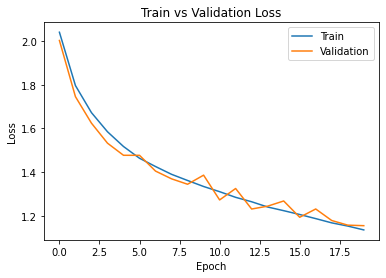

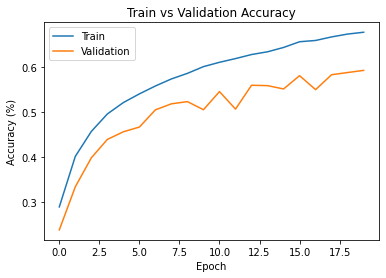

In [ ]:
train(LEARNING_RATE = 0.05)

### Q7.

## Using H2 hyperparameters on the test set
- because it has less loss after 20 epochs
- consistently decreasing loss after every epoch

In [ ]:
def test(BATCH = 3):
    samples, channels, width, height = X_test.shape
    # reshape into groups of BATCH size, (3, 32, 32) is the image's dimension
    test_predictions = [predict(mini_batch).argmax(1) 
        for mini_batch in X_test.reshape((-1, BATCH, 3, 32, 32))]
    test_predictions = np.array(test_predictions).flatten()
    test_acc = np.mean(test_predictions == Y_test)*100
    return test_acc

In [ ]:
print("Test Accuracy: %.2f" % (test()))

Test Accuracy: 57.4000


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


##**Problem 4. Open-Ended Exploration**

See the handout for instructions.